In [ ]:
from pathlib import Path
from dataclasses import asdict
from pprint import pprint

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# you may need this to access nebula package
# import sys
# sys.path.insert(1, '../')

from nebula.models.cnn import CNN
from nebula.modeling.trainers import (
    NoDATrainer,
    DAFixedLambdaTrainer,
    DATrainableWeightsTrainer,
    DATrainableWeightsSigmaTrainer,
    DAAdversarialTrainer,
)
from nebula.modeling.configs import (
    NoDAConfig,
    DAFixedLambdaConfig,
    DATrainableWeightsConfig,
    DATrainableWeightsSigmaConfig,
    DAAdversarialConfig,
)
from nebula.commons import set_all_seeds
from nebula.data.dataset import get_label_mappings
from nebula.data.dataloaders import GalaxyDataModule

from nebula.modeling.utils import plot_training_history, plot_diag_history

set_all_seeds()

## 1. Load Datasets

In [2]:
# paths
DATA_DIR = Path("../data")
source_img_dir = DATA_DIR / "source/galaxy_images_rgb"
source_labels = DATA_DIR / "source/source_galaxy_labels.csv"
target_img_dir = DATA_DIR / "target/gz2_images"
target_labels = DATA_DIR / "target/gz2_galaxy_labels_master.csv"

# target_img_dir = DATA_DIR / "target/gz_desi"
# target_labels = DATA_DIR / "target/gz_desi_labels.csvv"


data_module = GalaxyDataModule(
    source_img_dir=source_img_dir,
    source_labels=source_labels,
    target_img_dir=target_img_dir,
    target_labels=target_labels,
    include_rotations=False,  # for source dataset
    shared_norm=False,  # if True, normalize both datasets using source stats
    source_mean=None,
    source_std=None,
    target_mean=None,
    target_std=None,
    image_size=(28, 28),
    batch_size=64,
    val_size=0.2,
    num_workers=4,
    seed=42,
)

source_train_loader = data_module.source_train_loader
source_test_loader = data_module.source_test_loader
target_train_loader = data_module.target_train_loader
target_test_loader = data_module.target_test_loader

In [3]:
# print the means, stds
print("source_mean", data_module.source_mean)
print("source_std", data_module.source_std)
print("target_mean", data_module.target_mean)
print("target_std", data_module.target_std)

source_mean tensor([0.1085, 0.1175, 0.0912])
source_std tensor([0.1975, 0.2076, 0.1796])
target_mean tensor([0.0426, 0.0387, 0.0319])
target_std tensor([0.0781, 0.0678, 0.0676])


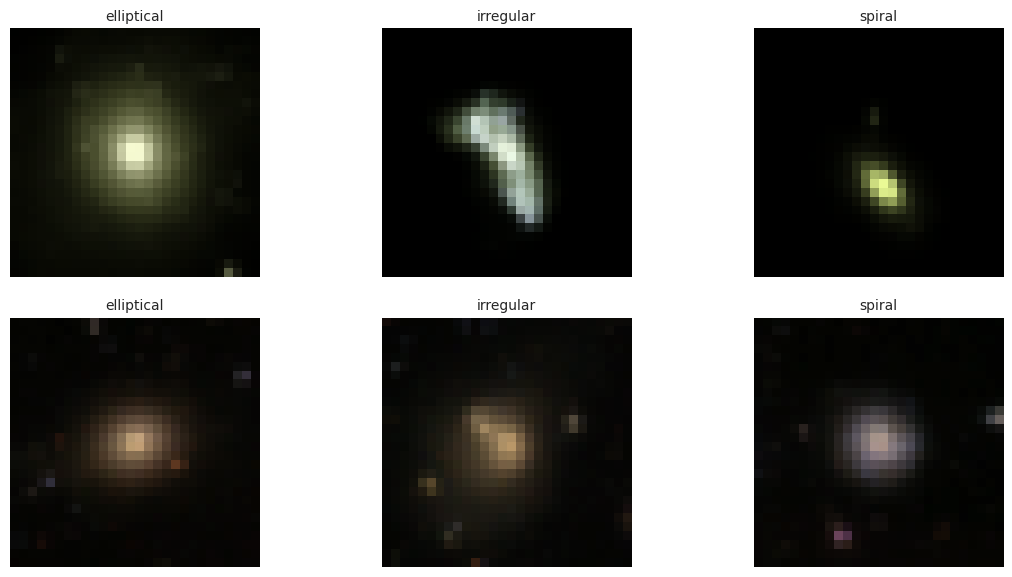

In [4]:
def get_examples_by_label(dataset):
    label_to_img = {}
    for img, label in dataset:
        label = int(label)
        if label not in label_to_img:
            label_to_img[label] = img
        if len(label_to_img) == 6:
            break
    return label_to_img


# Undo image normalization
def unnormalize(img, mean, std):
    img = img.clone()
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img


src_galaxy = get_examples_by_label(data_module.src_dataset)
tgt_galaxy = get_examples_by_label(data_module.tgt_dataset)
label2idx, idx2label = get_label_mappings()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for idx, image in enumerate(label2idx.values()):

    image_sdss = unnormalize(
        src_galaxy[image], data_module.source_mean, data_module.source_std
    )
    axes[0, idx].imshow(image_sdss.permute(1, 2, 0).numpy())
    axes[0, idx].set_title(f"{idx2label[idx]}", fontsize=10)
    axes[0, idx].axis("off")

    image_desi = unnormalize(
        tgt_galaxy[image], data_module.target_mean, data_module.target_std
    )
    axes[1, idx].imshow(image_desi.permute(1, 2, 0).numpy())
    axes[1, idx].set_title(f"{idx2label[idx]}", fontsize=10)
    axes[1, idx].axis("off")

axes[0, 0].set_ylabel("Source (TNG)", fontsize=12)
axes[1, 0].set_ylabel("Target (GZ2)", fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
#  Get a sample image from each dataset
src_img = next(iter(DataLoader(data_module.train_src, batch_size=1)))[0]
tgt_img = next(iter(DataLoader(data_module.train_tgt, batch_size=1)))[0]

# Print the shapes
print("Source image shape:", src_img.shape)  # should be (3, image_size, image_size)
print("Target image shape:", tgt_img.shape)  # should be (3, image_size, image_size)
print("Source image stats:", torch.mean(src_img), torch.std(src_img))
print("Target image stats:", torch.mean(tgt_img), torch.std(tgt_img))

Source image shape: torch.Size([1, 3, 28, 28])
Target image shape: torch.Size([1, 3, 28, 28])
Source image stats: tensor(-0.1394) tensor(0.9552)
Target image stats: tensor(0.1487) tensor(1.1460)


## 2. Baseline Training

The idea is to train the model on the source dataset only, without domain adaptation, and then test it on the target. We will use the `NoDAConfig` configuration, which is designed for this task.

In [6]:
# lets see the default config, and then pass different configs
config = NoDAConfig()
pprint(asdict(config))

{'class_weight_beta': 0.9999,
 'class_weight_method': 'effective',
 'criterion': 'cross_entropy',
 'early_stopping_metric': 'f1',
 'early_stopping_patience': None,
 'focal_alpha': None,
 'focal_gamma': 2.0,
 'focal_reduction': 'mean',
 'lr': 0.0001,
 'max_norm': 10.0,
 'num_epochs': 6,
 'optimizer': 'adamw',
 'use_class_weights': False,
 'weight_decay': 0.01}


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")
# 1. CE only (no DA)
image_size = (28, 28)
model_ce = CNN(input_size=(3, *image_size)).to(device)
config = NoDAConfig(num_epochs=10, lr=1e-4)
trainer = NoDATrainer(model_ce, config, device)
histories = trainer.train(
    source_train_loader
)  # no target loader needed, but we can pass it

using cuda


25-10-30 20:03:15 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:15 -  Epoch 1: CE=0.5745, DA=0.0000, SAcc=78.01%, TAcc=0.00%
25-10-30 20:03:15 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:18 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:18 -  Epoch 2: CE=0.4533, DA=0.0000, SAcc=83.38%, TAcc=0.00%
25-10-30 20:03:18 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:22 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:22 -  Epoch 3: CE=0.4315, DA=0.0000, SAcc=84.62%, TAcc=0.00%
25-10-30 20:03:22 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:25 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:25 -  Epoch 4: CE=0.4087, DA=0.0000, SAcc=85.04%, TAcc=0.00%
25-10-30 20:03:25 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:29 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:29 -  Epoch 5: CE=0.4278, DA=0.0000, SAcc=84.65%, TAcc=0.00%
25-10-30 20:03:29 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:32 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:32 -  Epoch 6: CE=0.4060, DA=0.0000, SAcc=84.85%, TAcc=0.00%
25-10-30 20:03:32 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:36 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:36 -  Epoch 7: CE=0.3817, DA=0.0000, SAcc=85.74%, TAcc=0.00%
25-10-30 20:03:36 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:39 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:39 -  Epoch 8: CE=0.3868, DA=0.0000, SAcc=86.08%, TAcc=0.00%
25-10-30 20:03:39 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:43 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:43 -  Epoch 9: CE=0.3691, DA=0.0000, SAcc=86.05%, TAcc=0.00%
25-10-30 20:03:43 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:03:46 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:03:46 -  Epoch 10: CE=0.3630, DA=0.0000, SAcc=86.08%, TAcc=0.00%
25-10-30 20:03:46 - └──────────────────────────────────────────────────────────────┘


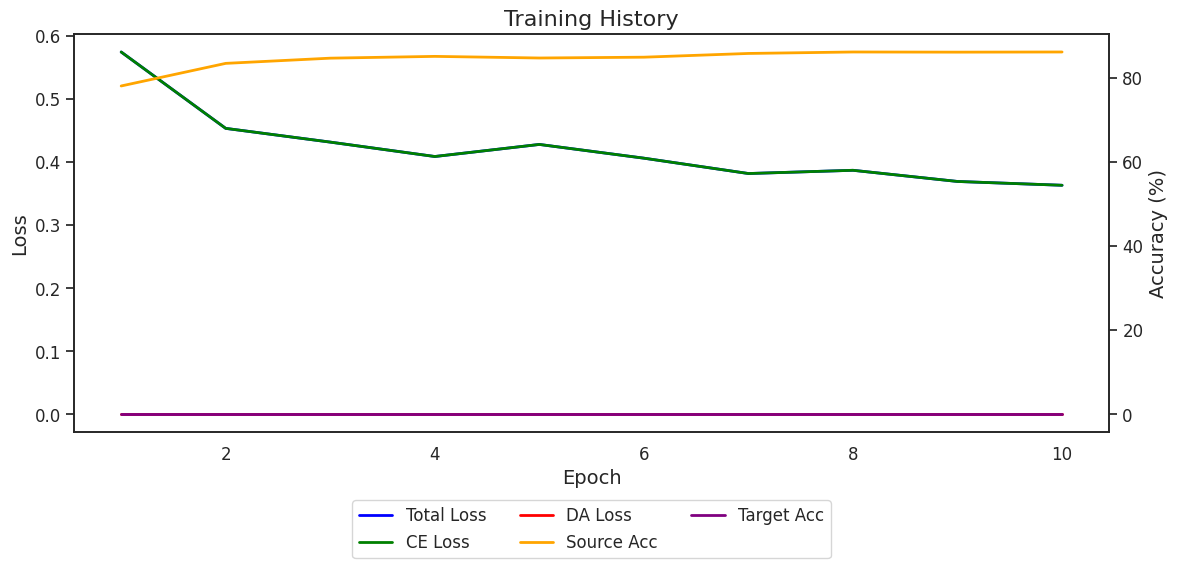

In [8]:
his = histories["history"]
his_fig = plot_training_history(his)

In [9]:
histories["history_df"].head()

,epoch,train_loss,ce_loss,da_loss,source_acc,target_acc,eta_1,eta_2
0,1,0.574470,0.574470,0.0,78.005412,0.0,None,None
1,2,0.453299,0.453299,0.0,83.378431,0.0,None,None
2,3,0.431514,0.431514,0.0,84.615385,0.0,None,None
3,4,0.408668,0.408668,0.0,85.040588,0.0,None,None
4,5,0.427818,0.427818,0.0,84.654039,0.0,None,None


In [10]:
src_acc = trainer.evaluate(source_test_loader)
tgt_acc = trainer.evaluate(target_test_loader)

print(f"Source Acc: {src_acc:.2f}%")
print(f"Target Acc: {tgt_acc:.2f}%")

Source Acc: 82.95%
Target Acc: 91.03%


## 2. Domain Adaptation with Fixed Lambda

In [11]:
da_config = DAFixedLambdaConfig()
pprint(asdict(da_config))

{'class_weight_beta': 0.9999,
 'class_weight_method': 'effective',
 'criterion': 'cross_entropy',
 'early_stopping_metric': 'f1',
 'early_stopping_patience': None,
 'focal_alpha': None,
 'focal_gamma': 2.0,
 'focal_reduction': 'mean',
 'lambda_da': 0.1,
 'lr': 0.0001,
 'max_norm': 10.0,
 'method': 'sinkhorn',
 'num_epochs': 6,
 'optimizer': 'adamw',
 'sinkhorn_blur': 10.0,
 'sinkhorn_p': 2,
 'use_class_weights': False,
 'weight_decay': 0.01}


## 2.1 Sinkhorn Fixed Lambda Training

In [12]:
# train
image_size = (28, 28)
s_f_model = CNN(input_size=(3, *image_size)).to(device)
da_fixed_cfg = DAFixedLambdaConfig(
    method="sinkhorn", num_epochs=10, lr=1e-4, lambda_da=0.1, sinkhorn_blur=10.0
)
da_fixed_trainer = DAFixedLambdaTrainer(s_f_model, da_fixed_cfg, device)
histories = da_fixed_trainer.train(source_train_loader, target_train_loader)

25-10-30 20:06:48 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:06:48 -  Epoch 1: CE=0.7654, DA=371.4755, SAcc=70.85%, TAcc=89.56%
25-10-30 20:06:48 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:06:52 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:06:52 -  Epoch 2: CE=0.7592, DA=62.0705, SAcc=71.28%, TAcc=91.88%
25-10-30 20:06:52 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:06:56 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:06:56 -  Epoch 3: CE=0.7378, DA=23.2326, SAcc=71.28%, TAcc=90.70%
25-10-30 20:06:56 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:07:00 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:07:00 -  Epoch 4: CE=0.7084, DA=6.7617, SAcc=72.40%, TAcc=91.01%
25-10-30 20:07:00 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:07:04 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:07:04 -  Epoch 5: CE=0.6809, DA=3.2018, SAcc=72.79%, TAcc=89.98%
25-10-30 20:07:04 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:07:08 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:07:08 -  Epoch 6: CE=0.6417, DA=1.8263, SAcc=75.22%, TAcc=88.49%
25-10-30 20:07:08 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:07:13 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:07:13 -  Epoch 7: CE=0.5975, DA=1.2325, SAcc=77.23%, TAcc=88.49%
25-10-30 20:07:13 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:07:17 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:07:17 -  Epoch 8: CE=0.5707, DA=1.0876, SAcc=78.66%, TAcc=87.84%
25-10-30 20:07:17 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:07:21 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:07:21 -  Epoch 9: CE=0.5590, DA=0.9412, SAcc=79.28%, TAcc=86.66%
25-10-30 20:07:21 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:07:25 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:07:25 -  Epoch 10: CE=0.5334, DA=0.8799, SAcc=80.09%, TAcc=85.79%
25-10-30 20:07:25 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:08:21 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:08:21 -   └─ Final Diagnostic: MMD²=0.0271, Sinkhorn=0.0064, 
25-10-30 20:08:21 -      Domain AUC=0.767, Domain Acc=0.695
25-10-30 20:08:21 -      Target Macro F1=0.33%, Target Acc=89.06%
25-10-30 20:08:21 -      Recall Elliptical=0.04%, Recall Irregular=0.00%, Recall Spiral=0.96%
25-10-30 20:08:21 - └────────────────────────────────────────────────────────────────────────────────────┘


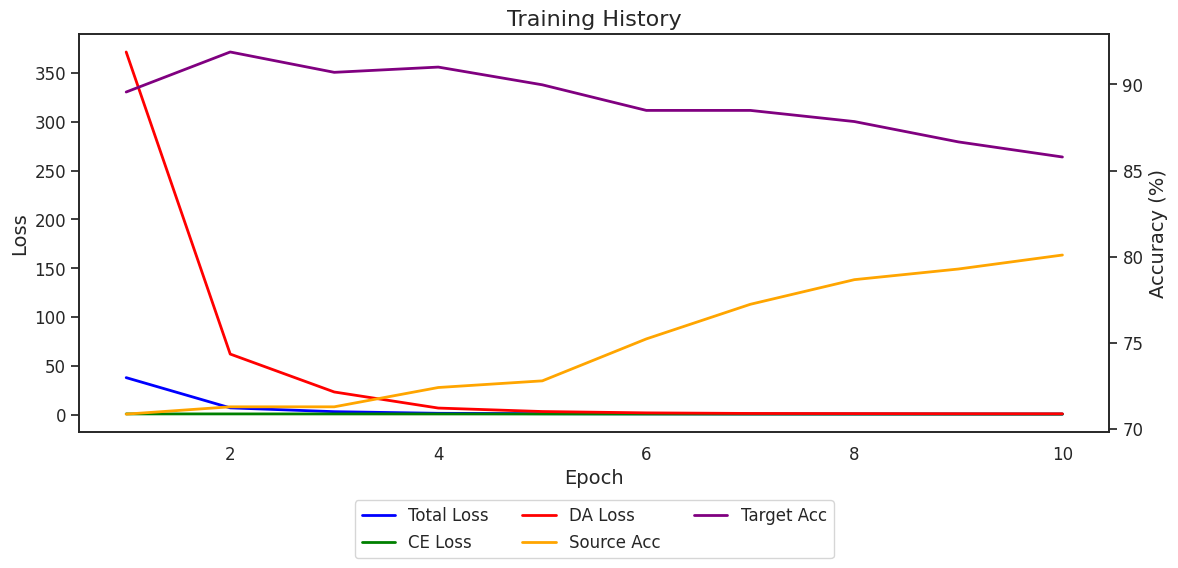

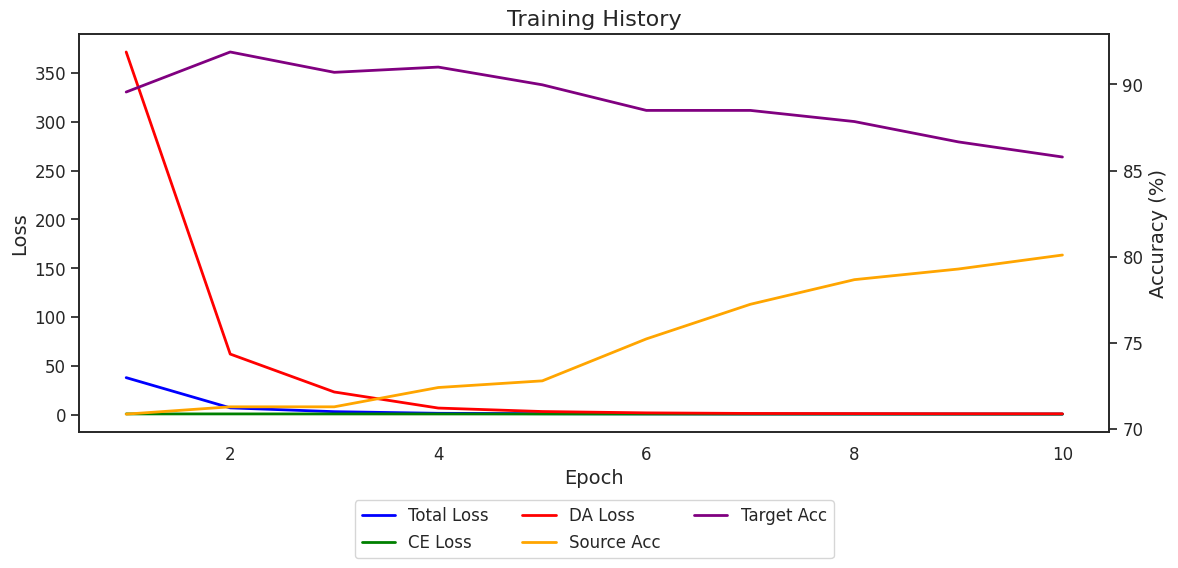

In [13]:
his = histories["history"]
fig = plot_training_history(his)

In [14]:
histories["diag_history_df"].columns

Index(['epoch', 'mmd2', 'sinkhorn_div', 'domain_auc', 'domain_acc',
       'proxy_a_distance', 'target_acc', 'target_macro_f1',
       'target_roc_auc_macro', 'target_roc_auc_weighted', 'target_auprc_macro',
       'target_auprc_weighted', 'recall_elliptical', 'recall_irregular',
       'recall_spiral', 'cmmd_elliptical', 'cmmd_irregular', 'cmmd_spiral',
       'domain_auc_elliptical', 'domain_auc_irregular', 'domain_auc_spiral',
       'ot_mass_elliptical_to_elliptical', 'ot_mass_elliptical_to_irregular',
       'ot_mass_elliptical_to_spiral', 'ot_mass_irregular_to_elliptical',
       'ot_mass_irregular_to_irregular', 'ot_mass_irregular_to_spiral',
       'ot_mass_spiral_to_elliptical', 'ot_mass_spiral_to_irregular',
       'ot_mass_spiral_to_spiral', 'ot_on_diag', 'outlier_scores',
       'outlier_mask', 'outlier_threshold', 'target_acc_non_outlier', 'embed',
       'src_z', 'tgt_z', 'src_y', 'tgt_y_true', 'tgt_y_pred', 'tgt_logits',
       'tgt_probas'],
      dtype='object')

In [15]:
# we can plot this, but the thing is the diagnosis was in the last epoch only
# diag_his = histories["diag_history"]
# fig2 = plot_diag_history(diag_his)
# lets enable that in our next trainer

In [16]:
src_acc = da_fixed_trainer.evaluate(source_test_loader)
tgt_acc = da_fixed_trainer.evaluate(target_test_loader)

print(f"Source Acc: {src_acc:.2f}%")
print(f"Target Acc: {tgt_acc:.2f}%")

Source Acc: 79.69%
Target Acc: 87.52%


## 2.2 MMD Fixed Lambda Training

In [17]:
image_size = (28, 28)
mmd_f_model = CNN(input_size=(3, *image_size)).to(device)
mmd_da_fixed_cfg = DAFixedLambdaConfig(
    method="mmd",
    num_epochs=10,
    lr=1e-4,
    lambda_da=0.1,
    sinkhorn_blur=10.0,
    sinkhorn_p=2,
)
mmd_da_fixed_trainer = DAFixedLambdaTrainer(mmd_f_model, mmd_da_fixed_cfg, device)

# eval_interval will diagnose every epoch on the target data, and save metrics
# NOTE: these metrics are not backpropagated
# NOTE: diag_max_batches is the number of batches to use for the diagnosis,
# Currently, its set to 10, so that's 10 batches * batch_size (64) = 640 target images
# Below metrics you may say that Recall Irregular is 0.00, they are minority so they could've not been in the batch
# Set to None to use all batches from target loader
histories = mmd_da_fixed_trainer.train(
    source_train_loader, target_train_loader, eval_interval=1, diag_max_batches=10
)

25-10-30 20:19:36 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:19:36 -  Epoch 1: CE=0.6073, DA=0.0191, SAcc=76.07%, TAcc=90.17%
25-10-30 20:19:36 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:20:28 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:20:28 -   └─ Diagnostic: MMD²=0.1665, Sinkhorn=0.2400, 
25-10-30 20:20:28 -      Domain AUC=1.000, Domain Acc=0.992
25-10-30 20:20:28 -      Target Macro F1=0.47%, Target Acc=92.81%
25-10-30 20:20:28 -      Recall Elliptical=0.31%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:20:28 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:20:32 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:20:32 -  Epoch 2: CE=0.4982, DA=0.0192, SAcc=81.91%, TAcc=92.11%
25-10-30 20:20:32 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:21:24 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:21:24 -   └─ Diagnostic: MMD²=0.1304, Sinkhorn=0.2318, 
25-10-30 20:21:24 -      Domain AUC=1.000, Domain Acc=0.992
25-10-30 20:21:24 -      Target Macro F1=0.31%, Target Acc=89.53%
25-10-30 20:21:24 -      Recall Elliptical=0.00%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:21:24 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:21:28 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:21:28 -  Epoch 3: CE=0.4682, DA=0.0190, SAcc=83.07%, TAcc=91.46%
25-10-30 20:21:28 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:22:21 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:22:21 -   └─ Diagnostic: MMD²=0.1376, Sinkhorn=0.2659, 
25-10-30 20:22:21 -      Domain AUC=1.000, Domain Acc=0.992
25-10-30 20:22:21 -      Target Macro F1=0.31%, Target Acc=89.06%
25-10-30 20:22:21 -      Recall Elliptical=0.00%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:22:21 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:22:25 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:22:25 -  Epoch 4: CE=0.4395, DA=0.0187, SAcc=84.15%, TAcc=91.54%
25-10-30 20:22:25 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:23:19 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:23:19 -   └─ Diagnostic: MMD²=0.1395, Sinkhorn=0.2679, 
25-10-30 20:23:19 -      Domain AUC=1.000, Domain Acc=1.000
25-10-30 20:23:19 -      Target Macro F1=0.32%, Target Acc=90.62%
25-10-30 20:23:19 -      Recall Elliptical=0.00%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:23:19 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:23:23 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:23:23 -  Epoch 5: CE=0.4176, DA=0.0184, SAcc=85.47%, TAcc=91.08%
25-10-30 20:23:23 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:24:16 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:24:16 -   └─ Diagnostic: MMD²=0.1225, Sinkhorn=0.2535, 
25-10-30 20:24:16 -      Domain AUC=1.000, Domain Acc=0.995
25-10-30 20:24:16 -      Target Macro F1=0.32%, Target Acc=90.62%
25-10-30 20:24:16 -      Recall Elliptical=0.00%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:24:16 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:24:20 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:24:20 -  Epoch 6: CE=0.4543, DA=0.0189, SAcc=83.65%, TAcc=91.20%
25-10-30 20:24:20 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:25:09 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:25:09 -   └─ Diagnostic: MMD²=0.1409, Sinkhorn=0.2930, 
25-10-30 20:25:09 -      Domain AUC=1.000, Domain Acc=0.969
25-10-30 20:25:09 -      Target Macro F1=0.37%, Target Acc=93.44%
25-10-30 20:25:09 -      Recall Elliptical=0.07%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:25:09 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:25:13 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:25:13 -  Epoch 7: CE=0.4082, DA=0.0182, SAcc=85.35%, TAcc=91.73%
25-10-30 20:25:13 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:25:59 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:25:59 -   └─ Diagnostic: MMD²=0.1290, Sinkhorn=0.2709, 
25-10-30 20:25:59 -      Domain AUC=1.000, Domain Acc=0.979
25-10-30 20:25:59 -      Target Macro F1=0.33%, Target Acc=90.31%
25-10-30 20:25:59 -      Recall Elliptical=0.02%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:25:59 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:26:03 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:26:03 -  Epoch 8: CE=0.4111, DA=0.0186, SAcc=85.50%, TAcc=91.01%
25-10-30 20:26:03 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:27:00 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:27:00 -   └─ Diagnostic: MMD²=0.1081, Sinkhorn=0.2511, 
25-10-30 20:27:00 -      Domain AUC=0.999, Domain Acc=0.966
25-10-30 20:27:00 -      Target Macro F1=0.32%, Target Acc=90.47%
25-10-30 20:27:00 -      Recall Elliptical=0.00%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:27:00 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:27:04 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:27:04 -  Epoch 9: CE=0.3923, DA=0.0181, SAcc=85.50%, TAcc=91.08%
25-10-30 20:27:04 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:27:51 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:27:51 -   └─ Diagnostic: MMD²=0.1043, Sinkhorn=0.2630, 
25-10-30 20:27:51 -      Domain AUC=0.999, Domain Acc=0.992
25-10-30 20:27:51 -      Target Macro F1=0.32%, Target Acc=91.09%
25-10-30 20:27:51 -      Recall Elliptical=0.00%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:27:51 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:27:55 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:27:55 -  Epoch 10: CE=0.3977, DA=0.0179, SAcc=85.08%, TAcc=91.50%
25-10-30 20:27:55 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:28:37 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:28:37 -   └─ Diagnostic: MMD²=0.0977, Sinkhorn=0.2766, 
25-10-30 20:28:37 -      Domain AUC=1.000, Domain Acc=0.984
25-10-30 20:28:37 -      Target Macro F1=0.34%, Target Acc=90.94%
25-10-30 20:28:37 -      Recall Elliptical=0.03%, Recall Irregular=0.00%, Recall Spiral=1.00%
25-10-30 20:28:37 - └────────────────────────────────────────────────────────────────────────────────────┘


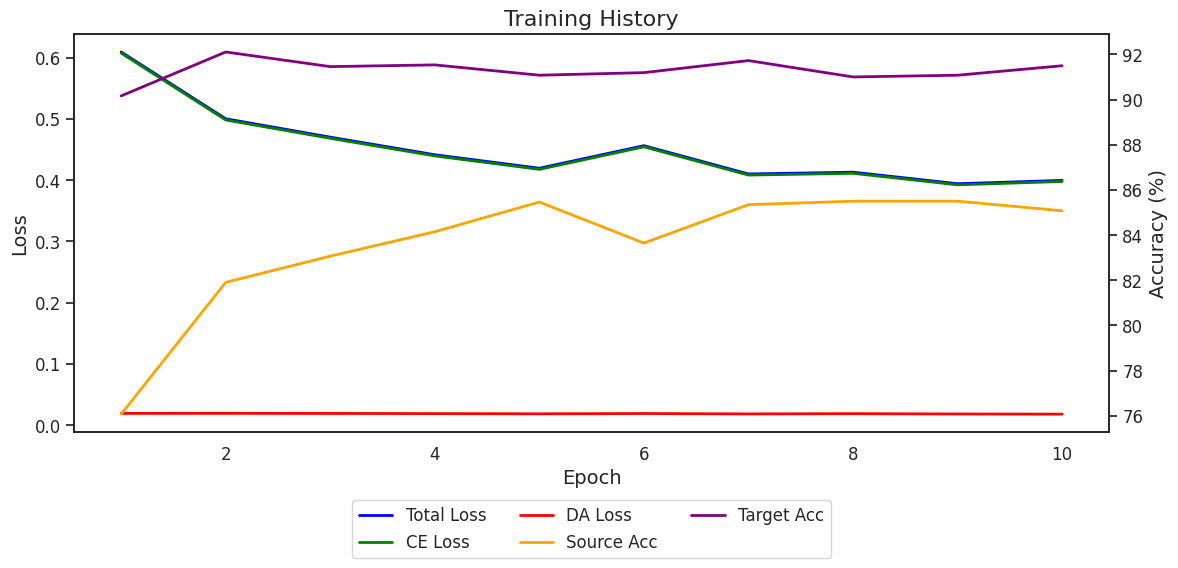

In [18]:
his = histories["history"]
fig = plot_training_history(his)

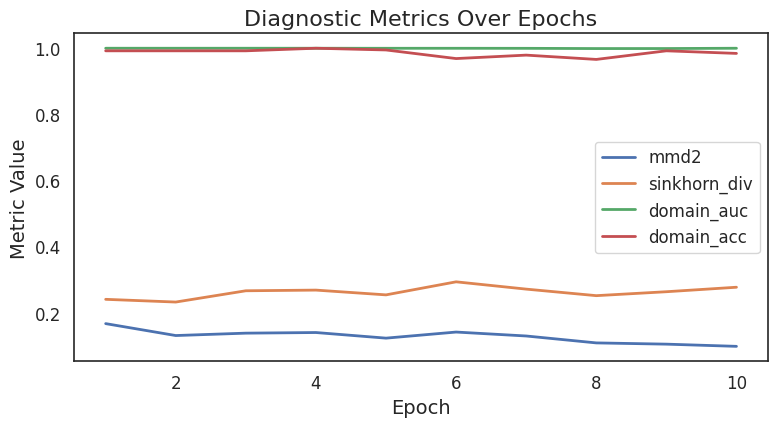

In [19]:
diag_his = histories["diag_history"]
_ = plot_diag_history(diag_his)

## 2.3 Energy Fixed Lambda Training

In [20]:
image_size = (28, 28)
energy_f_model = CNN(input_size=(3, *image_size)).to(device)
energy_da_fixed_cfg = DAFixedLambdaConfig(
    method="energy", num_epochs=10, lr=1e-4, lambda_da=0.1
)
energy_da_fixed_trainer = DAFixedLambdaTrainer(
    energy_f_model, energy_da_fixed_cfg, device
)
histories = energy_da_fixed_trainer.train(source_train_loader, target_train_loader)

## 3. Trainable Weights (η1, η2)

In [21]:
c = DATrainableWeightsConfig()
pprint(asdict(c))

{'class_weight_beta': 0.9999,
 'class_weight_method': 'effective',
 'criterion': 'cross_entropy',
 'early_stopping_metric': 'f1',
 'early_stopping_patience': None,
 'eta_1_init': 0.1,
 'eta_2_init': 1.0,
 'focal_alpha': None,
 'focal_gamma': 2.0,
 'focal_reduction': 'mean',
 'lambda_da': 0.1,
 'lr': 0.0001,
 'max_norm': 10.0,
 'method': 'sinkhorn',
 'num_epochs': 6,
 'optimizer': 'adamw',
 'sinkhorn_blur': 10.0,
 'sinkhorn_p': 2,
 'use_class_weights': False,
 'weight_decay': 0.01}


In [22]:
tw_model = CNN(input_size=(3, *image_size)).to(device)
tw_cfg = DATrainableWeightsConfig(
    method="sinkhorn",
    num_epochs=10,
    lr=1e-4,
    lambda_da=0.1,
    sinkhorn_blur=10.0,
    sinkhorn_p=2,
    eta_1_init=0.1,
    eta_2_init=1.0,
)
tw_trainer = DATrainableWeightsTrainer(tw_model, tw_cfg, device)
histories = tw_trainer.train(
    source_train_loader,
    target_train_loader,
    eval_interval=0,  # only diagnose on the last epoch
    diag_max_batches=10,
)

25-10-30 20:38:44 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:38:44 -  Epoch 1: CE=0.7628, DA=371.6806, SAcc=70.85%, TAcc=89.56%
25-10-30 20:38:44 -            eta_1=0.1004, eta_2=1.0021
25-10-30 20:38:44 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:38:48 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:38:48 -  Epoch 2: CE=0.7445, DA=62.9873, SAcc=71.28%, TAcc=91.88%
25-10-30 20:38:48 -            eta_1=0.1008, eta_2=1.0027
25-10-30 20:38:48 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:38:52 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:38:52 -  Epoch 3: CE=0.6860, DA=25.7336, SAcc=72.01%, TAcc=90.70%
25-10-30 20:38:52 -            eta_1=0.1012, eta_2=1.0030
25-10-30 20:38:52 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:38:56 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:38:56 -  Epoch 4: CE=0.6140, DA=10.7233, SAcc=76.46%, TAcc=89.52%
25-10-30 20:38:56 -            eta_1=0.1016, eta_2=1.0032
25-10-30 20:38:56 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:39:00 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:39:00 -  Epoch 5: CE=0.5695, DA=7.1066, SAcc=78.89%, TAcc=87.04%
25-10-30 20:39:00 -            eta_1=0.1019, eta_2=1.0033
25-10-30 20:39:00 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:39:04 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:39:04 -  Epoch 6: CE=0.5290, DA=5.5406, SAcc=80.94%, TAcc=85.48%
25-10-30 20:39:04 -            eta_1=0.1023, eta_2=1.0033
25-10-30 20:39:04 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:39:09 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:39:09 -  Epoch 7: CE=0.4927, DA=4.7738, SAcc=82.22%, TAcc=85.79%
25-10-30 20:39:09 -            eta_1=0.1026, eta_2=1.0034
25-10-30 20:39:09 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:39:13 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:39:13 -  Epoch 8: CE=0.4849, DA=4.6189, SAcc=82.72%, TAcc=85.37%
25-10-30 20:39:13 -            eta_1=0.1029, eta_2=1.0035
25-10-30 20:39:13 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:39:17 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:39:17 -  Epoch 9: CE=0.4907, DA=4.1238, SAcc=82.14%, TAcc=85.14%
25-10-30 20:39:17 -            eta_1=0.1033, eta_2=1.0036
25-10-30 20:39:17 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:39:21 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:39:21 -  Epoch 10: CE=0.4683, DA=4.1644, SAcc=82.88%, TAcc=85.10%
25-10-30 20:39:21 -            eta_1=0.1036, eta_2=1.0036
25-10-30 20:39:21 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:40:13 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:40:13 -   └─ Final Diagnostic: MMD²=0.0226, Sinkhorn=0.0147, 
25-10-30 20:40:13 -      Domain AUC=0.936, Domain Acc=0.893
25-10-30 20:40:13 -      Target Macro F1=0.38%, Target Acc=88.75%
25-10-30 20:40:13 -      Recall Elliptical=0.24%, Recall Irregular=0.00%, Recall Spiral=0.95%
25-10-30 20:40:13 - └────────────────────────────────────────────────────────────────────────────────────┘


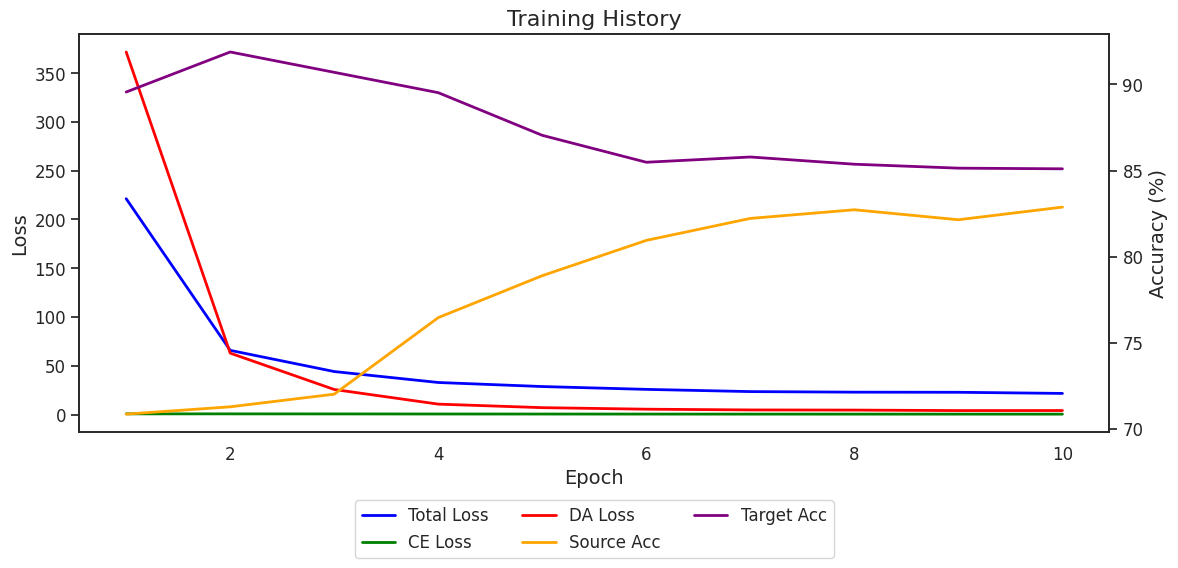

In [23]:
_ = plot_training_history(histories["history"])

In [24]:
src_acc = tw_trainer.evaluate(source_test_loader)
tgt_acc = tw_trainer.evaluate(target_test_loader)
print(f"[Trainable Weights]")
print(f"Source Acc: {src_acc:.2f}%")
print(f"Target Acc: {tgt_acc:.2f}%")

[Trainable Weights]
Source Acc: 82.64%
Target Acc: 86.12%


## 4. Trainable Weights + Sigma Schedule

In [25]:
c = DATrainableWeightsSigmaConfig()
pprint(asdict(c))

{'class_weight_beta': 0.9999,
 'class_weight_method': 'effective',
 'criterion': 'cross_entropy',
 'early_stopping_metric': 'f1',
 'early_stopping_patience': None,
 'eta_1_init': 0.1,
 'eta_2_init': 1.0,
 'focal_alpha': None,
 'focal_gamma': 2.0,
 'focal_reduction': 'mean',
 'lambda_da': 0.1,
 'lr': 0.0001,
 'max_norm': 10.0,
 'method': 'sinkhorn',
 'num_epochs': 6,
 'optimizer': 'adamw',
 'sigma_decay_rate': 0.6,
 'sigma_final_blur': 1.0,
 'sigma_initial_blur': 10.0,
 'sigma_min_blur': 0.01,
 'sigma_poly_power': 2.0,
 'sigma_schedule_type': 'exponential',
 'sigma_step_gamma': 0.5,
 'sigma_step_size': 2,
 'sinkhorn_blur': 10.0,
 'sinkhorn_p': 2,
 'use_class_weights': False,
 'weight_decay': 0.01}


In [26]:
tws_model = CNN(input_size=(3, *image_size)).to(device)
tws_cfg = DATrainableWeightsSigmaConfig(
    method="sinkhorn",
    num_epochs=10,
    lr=1e-4,
    lambda_da=0.1,
    sinkhorn_blur=10.0,  # initial blur; scheduler will update during training
    sinkhorn_p=2,
    eta_1_init=0.1,
    eta_2_init=1.0,
    sigma_schedule_type="exponential",  # "exponential" | "linear" | "cosine" | "step" | "polynomial"
    sigma_initial_blur=10.0,
    sigma_decay_rate=0.6,
    sigma_final_blur=1.0,
    sigma_step_size=2,
    sigma_step_gamma=0.5,
    sigma_poly_power=2.0,
    early_stopping_patience=3,
    early_stopping_metric="accuracy",
)
tws_trainer = DATrainableWeightsSigmaTrainer(tws_model, tws_cfg, device)
histories = tws_trainer.train(
    source_train_loader,
    target_train_loader,
    eval_interval=0,
    diag_max_batches=10,
)

25-10-30 20:42:19 - Enabled early stopping criterion=accuracy, mode=max, patience=3



25-10-30 20:42:23 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:42:23 -  Epoch 1: CE=0.7566, DA=315.8317, SAcc=70.97%, TAcc=90.97%
25-10-30 20:42:23 -            eta_1=0.1004, eta_2=1.0021
25-10-30 20:42:23 -            sigma=10.0000
25-10-30 20:42:26 -  Target Accuracy: 91.14%
25-10-30 20:42:26 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:42:30 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:42:30 -  Epoch 2: CE=0.7481, DA=64.9563, SAcc=71.32%, TAcc=90.85%
25-10-30 20:42:30 -            eta_1=0.1008, eta_2=1.0028
25-10-30 20:42:30 -            sigma=6.0000
25-10-30 20:42:33 -  Target Accuracy: 91.14%
25-10-30 20:42:33 -  EarlyStopping counter: 1/3 (best accuracy: 91.1375)
25-10-30 20:42:33 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:42:37 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:42:37 -  Epoch 3: CE=0.7167, DA=44.5573, SAcc=71.24%, TAcc=90.59%
25-10-30 20:42:37 -            eta_1=0.1012, eta_2=1.0034
25-10-30 20:42:37 -            sigma=3.6000
25-10-30 20:42:40 -  Target Accuracy: 91.14%
25-10-30 20:42:40 -  EarlyStopping counter: 2/3 (best accuracy: 91.1375)
25-10-30 20:42:40 - └──────────────────────────────────────────────────────────────┘


25-10-30 20:42:44 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:42:44 -  Epoch 4: CE=0.6541, DA=33.5531, SAcc=73.56%, TAcc=91.16%
25-10-30 20:42:44 -            eta_1=0.1016, eta_2=1.0039
25-10-30 20:42:44 -            sigma=2.1600
25-10-30 20:42:47 -  Target Accuracy: 90.46%
25-10-30 20:42:47 -  EarlyStopping counter: 3/3 (best accuracy: 91.1375)
25-10-30 20:42:47 - Early stopping triggered! No improvement in accuracy for 3 epochs.
25-10-30 20:42:47 - Best accuracy: 91.1375
25-10-30 20:42:47 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:43:40 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:43:40 -   └─ Final Diagnostic: MMD²=0.0348, Sinkhorn=0.0140, 
25-10-30 20:43:40 -      Domain AUC=0.939, Domain Acc=0.823
25-10-30 20:43:40 -      Target Macro F1=0.32%, Target Acc=91.25%
25-10-30 20:43:40 -      Recall Elliptical=0.00%, Recall Irregular=0.00%, Recall Spiral=1.00%
2

In [27]:
src_acc = tws_trainer.evaluate(source_test_loader)
tgt_acc = tws_trainer.evaluate(target_test_loader)
print(f"[Trainable Weights + Sigma Schedule]")
print(f"Source Acc: {src_acc:.2f}%")
print(f"Target Acc: {tgt_acc:.2f}%")

[Trainable Weights + Sigma Schedule]
Source Acc: 76.90%
Target Acc: 90.33%


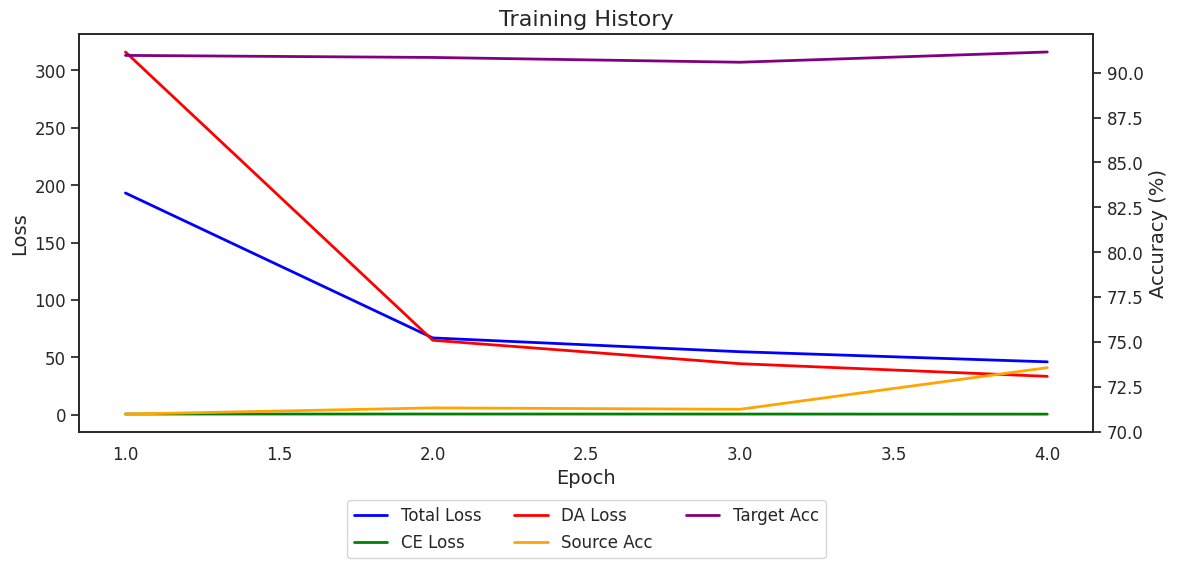

In [28]:
_ = plot_training_history(histories["history"])

## 5. Adversarial Domain Adaptation (DANN/GRL)

In [29]:
adv_model = CNN(input_size=(3, *image_size)).to(device)
with torch.no_grad():
    _dummy = torch.randn(1, 3, *image_size).to(device)
    _, dummy_latent = adv_model(_dummy)
adv_cfg = DAAdversarialConfig(
    num_epochs=10,
    lr=1e-4,
    lambda_grl=0.25,
    latent_dim=int(dummy_latent.shape[1]),
    domain_hidden_dim=256,
    use_projection=False,
    domain_projection_dim=128,
)
adv_trainer = DAAdversarialTrainer(adv_model, adv_cfg, device)
histories = adv_trainer.train(
    source_train_loader,
    target_train_loader,
    eval_interval=1,
    diag_max_batches=10,
)

src_acc = adv_trainer.evaluate(source_test_loader)
tgt_acc = adv_trainer.evaluate(target_test_loader)
print(f"[Adversarial] Source Acc: {src_acc:.2f}% | Target Acc: {tgt_acc:.2f}%")

25-10-30 20:45:44 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:45:44 -  Epoch 1: CE=0.6315, DA=0.3946, SAcc=73.99%, TAcc=89.10%
25-10-30 20:45:44 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:46:34 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:46:34 -   └─ Diagnostic: MMD²=0.2773, Sinkhorn=0.2474, 
25-10-30 20:46:34 -      Domain AUC=1.000, Domain Acc=1.000
25-10-30 20:46:34 -      Target Macro F1=0.44%, Target Acc=92.03%
25-10-30 20:46:34 -      Recall Elliptical=0.27%, Recall Irregular=0.00%, Recall Spiral=0.99%
25-10-30 20:46:34 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:46:38 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:46:38 -  Epoch 2: CE=0.5619, DA=1.6136, SAcc=78.89%, TAcc=88.80%
25-10-30 20:46:38 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:47:34 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:47:34 -   └─ Diagnostic: MMD²=0.5555, Sinkhorn=0.3855, 
25-10-30 20:47:34 -      Domain AUC=1.000, Domain Acc=0.992
25-10-30 20:47:34 -      Target Macro F1=0.34%, Target Acc=91.41%
25-10-30 20:47:34 -      Recall Elliptical=0.03%, Recall Irregular=0.00%, Recall Spiral=0.99%
25-10-30 20:47:34 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:47:38 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:47:38 -  Epoch 3: CE=0.5523, DA=0.8281, SAcc=79.63%, TAcc=91.23%
25-10-30 20:47:38 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:48:26 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:48:26 -   └─ Diagnostic: MMD²=0.5497, Sinkhorn=0.3441, 
25-10-30 20:48:26 -      Domain AUC=1.000, Domain Acc=0.995
25-10-30 20:48:26 -      Target Macro F1=0.38%, Target Acc=92.34%
25-10-30 20:48:26 -      Recall Elliptical=0.11%, Recall Irregular=0.00%, Recall Spiral=0.99%
25-10-30 20:48:26 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:48:29 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:48:29 -  Epoch 4: CE=0.5210, DA=0.4754, SAcc=80.44%, TAcc=91.01%
25-10-30 20:48:29 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:49:15 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:49:15 -   └─ Diagnostic: MMD²=0.5318, Sinkhorn=0.4103, 
25-10-30 20:49:15 -      Domain AUC=1.000, Domain Acc=0.987
25-10-30 20:49:15 -      Target Macro F1=0.39%, Target Acc=92.34%
25-10-30 20:49:15 -      Recall Elliptical=0.14%, Recall Irregular=0.00%, Recall Spiral=0.99%
25-10-30 20:49:15 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:49:19 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:49:19 -  Epoch 5: CE=0.4893, DA=0.3507, SAcc=82.26%, TAcc=91.31%
25-10-30 20:49:19 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:50:12 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:50:12 -   └─ Diagnostic: MMD²=0.1604, Sinkhorn=0.1734, 
25-10-30 20:50:12 -      Domain AUC=0.999, Domain Acc=0.992
25-10-30 20:50:12 -      Target Macro F1=0.38%, Target Acc=90.94%
25-10-30 20:50:12 -      Recall Elliptical=0.11%, Recall Irregular=0.00%, Recall Spiral=0.99%
25-10-30 20:50:12 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:50:16 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:50:16 -  Epoch 6: CE=0.4879, DA=0.5640, SAcc=82.57%, TAcc=90.13%
25-10-30 20:50:16 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:51:11 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:51:11 -   └─ Diagnostic: MMD²=0.2411, Sinkhorn=0.2031, 
25-10-30 20:51:11 -      Domain AUC=1.000, Domain Acc=1.000
25-10-30 20:51:11 -      Target Macro F1=0.45%, Target Acc=91.56%
25-10-30 20:51:11 -      Recall Elliptical=0.39%, Recall Irregular=0.00%, Recall Spiral=0.98%
25-10-30 20:51:11 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:51:15 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:51:15 -  Epoch 7: CE=0.4700, DA=0.4551, SAcc=83.15%, TAcc=90.62%
25-10-30 20:51:15 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:52:05 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:52:05 -   └─ Diagnostic: MMD²=0.1816, Sinkhorn=0.2022, 
25-10-30 20:52:05 -      Domain AUC=1.000, Domain Acc=0.992
25-10-30 20:52:05 -      Target Macro F1=0.43%, Target Acc=90.16%
25-10-30 20:52:05 -      Recall Elliptical=0.36%, Recall Irregular=0.00%, Recall Spiral=0.97%
25-10-30 20:52:05 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:52:08 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:52:08 -  Epoch 8: CE=0.4816, DA=0.6157, SAcc=82.37%, TAcc=90.21%
25-10-30 20:52:08 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:53:01 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:53:01 -   └─ Diagnostic: MMD²=0.2932, Sinkhorn=0.2036, 
25-10-30 20:53:01 -      Domain AUC=1.000, Domain Acc=0.995
25-10-30 20:53:01 -      Target Macro F1=0.43%, Target Acc=91.56%
25-10-30 20:53:01 -      Recall Elliptical=0.38%, Recall Irregular=0.00%, Recall Spiral=0.97%
25-10-30 20:53:01 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:53:06 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:53:06 -  Epoch 9: CE=0.4751, DA=0.4495, SAcc=83.03%, TAcc=89.25%
25-10-30 20:53:06 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:53:59 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:53:59 -   └─ Diagnostic: MMD²=0.3548, Sinkhorn=0.2682, 
25-10-30 20:53:59 -      Domain AUC=0.999, Domain Acc=0.977
25-10-30 20:53:59 -      Target Macro F1=0.44%, Target Acc=89.06%
25-10-30 20:53:59 -      Recall Elliptical=0.53%, Recall Irregular=0.00%, Recall Spiral=0.94%
25-10-30 20:53:59 - └────────────────────────────────────────────────────────────────────────────────────┘


25-10-30 20:54:03 - ┌──────────────────────────────────────────────────────────────┐
25-10-30 20:54:03 -  Epoch 10: CE=0.4563, DA=0.5442, SAcc=83.73%, TAcc=90.85%
25-10-30 20:54:03 - └──────────────────────────────────────────────────────────────┘
25-10-30 20:54:53 - ┌────────────────────────────────────────────────────────────────────────────────────┐
25-10-30 20:54:53 -   └─ Diagnostic: MMD²=0.2465, Sinkhorn=0.2312, 
25-10-30 20:54:53 -      Domain AUC=1.000, Domain Acc=0.992
25-10-30 20:54:53 -      Target Macro F1=0.42%, Target Acc=86.88%
25-10-30 20:54:53 -      Recall Elliptical=0.66%, Recall Irregular=0.00%, Recall Spiral=0.91%
25-10-30 20:54:53 - └────────────────────────────────────────────────────────────────────────────────────┘
[Adversarial] Source Acc: 81.24% | Target Acc: 91.26%


In [30]:
src_acc = adv_trainer.evaluate(source_test_loader)
tgt_acc = adv_trainer.evaluate(target_test_loader)
print(f"[Adversarial]")
print(f"Source Acc: {src_acc:.2f}%")
print(f"Target Acc: {tgt_acc:.2f}%")

[Adversarial]
Source Acc: 81.24%
Target Acc: 91.26%
